In [1]:
import os

# 수학 관련 라이브러리
import numpy as np
import math

import sys

# pytorch 관련 라이브러리
import torch
import torch.nn as nn 
import torch.nn.functional as F 

# visualization 라이브러리
import matplotlib.pyplot as plt

# sample input

In [2]:
sample_input = torch.tensor([[    1,    57,  3518,   155,     6,   943, 10716, 20433,     0,     6,
         12181,   362,     4,   588,   245,   243,   230,   241,   231,   240,
           233,   238,   239,   232,     4,  1761,    20,     2,  5063,  1007,
          2085,  2907,     4, 19454,   658,  5499,  8778,  1132,  4189,   283,
             4,     4,    20,     2,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

sample_mask1 = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


sample_mask2 = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])



sample_label = torch.tensor([0])

sample = [sample_input,sample_mask2,sample_mask1,sample_label]

sample_config = {
    "dim": 768,
    "dim_ff": 3072,
    "n_layers": 12,
    "p_drop_attn": 0.1,
    "n_heads": 12,
    "p_drop_hidden": 0.1,
    "max_len": 512,
    "n_segments": 2,
    "vocab_size": 30522
}

class AttributeDict(dict):
    def __getattr__(self, name):
        return self[name]
model_config = AttributeDict(sample_config)

In [3]:
sample_input.size()

torch.Size([1, 128])

# Activation function

In [4]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

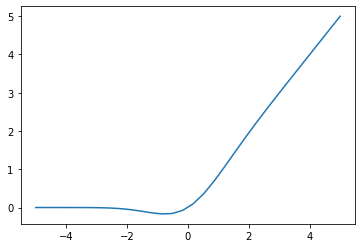

In [5]:
x = torch.linspace(-5,5,30)
plt.plot(x,gelu(x))
plt.show()

# Layer normalization

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, cfg, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(cfg.dim))
        self.beta  = nn.Parameter(torch.zeros(cfg.dim))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        # get mean, variance
        u = x.mean(-1, keepdim=True) # 각 단어별 mean
        s = (x - u).pow(2).mean(-1, keepdim=True) # 각 단어별 variance
        
        # normalize
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # (x - mean)/std 
        
        return self.gamma * x + self.beta # gamma, beta를 이용해 mean, std 조정

# Embedding

In [7]:
class Embeddings(nn.Module):
    "The embedding module from word, position and token_type embeddings."
    def __init__(self, cfg):
        super().__init__()
        self.tok_embed = nn.Embedding(cfg.vocab_size, cfg.dim) # token embedding
        self.pos_embed = nn.Embedding(cfg.max_len, cfg.dim) # position embedding
        self.seg_embed = nn.Embedding(cfg.n_segments, cfg.dim) # segment(token type) embedding

        self.norm = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device) # 0,1,2,3,4,5, ..., seq_len-1
        pos = pos.unsqueeze(0).expand_as(x) # (S,) -> (B, S)

        e = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.drop(self.norm(e))

In [8]:
model = Embeddings(model_config)

In [9]:
out = model(*sample[0:2])
out.size()


torch.Size([1, 128, 768])

In [10]:
sample[0]

tensor([[    1,    57,  3518,   155,     6,   943, 10716, 20433,     0,     6,
         12181,   362,     4,   588,   245,   243,   230,   241,   231,   240,
           233,   238,   239,   232,     4,  1761,    20,     2,  5063,  1007,
          2085,  2907,     4, 19454,   658,  5499,  8778,  1132,  4189,   283,
             4,     4,    20,     2,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [11]:
out[0,-5:] # 뒤의 5개는 모두 pad 토큰인데 embedding 값이 다릅니다. 그 이유가 뭘까요?

tensor([[ 0.3233,  1.3021,  0.0000,  ...,  1.2345,  1.3064,  1.1453],
        [-1.6845,  1.1804,  0.8632,  ..., -0.0000,  1.2621,  0.3760],
        [-0.9437, -1.5301,  1.1847,  ...,  0.0872,  0.9528,  0.3047],
        [-0.9913,  0.3079,  1.3523,  ..., -0.0000,  1.3691,  0.1057],
        [-1.4005,  0.8539,  2.0624,  ..., -0.8189,  0.7783,  0.5539]],
       grad_fn=<SliceBackward0>)

#  Transformer encoder

In [12]:
class Attention(nn.Module):
    #Scaled Dot Product Attention
    
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1)) # scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [13]:
class MultiHeadedSelfAttention(nn.Module):
    """ Multi-Headed Dot Product Attention """
    def __init__(self, cfg):
        super().__init__()
        self.proj_q = nn.Linear(cfg.dim, cfg.dim)
        self.proj_k = nn.Linear(cfg.dim, cfg.dim)
        self.proj_v = nn.Linear(cfg.dim, cfg.dim)
        self.drop = nn.Dropout(cfg.p_drop_attn)
        self.scores = None # for visualization
        self.n_heads = cfg.n_heads

    def forward(self, x, mask):
        """
        x, q(query), k(key), v(value) : (B(batch_size), S(seq_len), D(dim))
        mask : (B(batch_size) x S(seq_len))
        * split D(dim) into (H(n_heads), W(width of head)) ; D = H * W
        """
        B,S,D = x.shape


        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        
        q, k, v = (x.reshape(B,S,self.n_heads,-1).transpose(1, 2)
                   for x in [q, k, v])
        # (B, H, S, W) @ (B, H, W, S) -> (B, H, S, S) -softmax-> (B, H, S, S)
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1)) # @ == torch.matmul (dot product)
        if mask is not None:
            mask = mask[:, None, None, :].float()
            scores -= 10000.0 * (1.0 - mask)
        scores = self.drop(F.softmax(scores, dim=-1))
        # (B, H, S, S) @ (B, H, S, W) -> (B, H, S, W) -trans-> (B, S, H, W)
        h = (scores @ v).transpose(1, 2).contiguous()
        # -merge-> (B, S, D)
        h = h.reshape(B,S,D)
        self.scores = scores
        return h

# Base feedforward network

In [14]:
class PositionWiseFeedForward(nn.Module):
    """ FeedForward Neural Networks for each position """
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg.dim, cfg.dim_ff)
        self.fc2 = nn.Linear(cfg.dim_ff, cfg.dim)

    def forward(self, x):
        # (B, S, D) -> (B, S, D_ff) -> (B, S, D)
        return self.fc2(gelu(self.fc1(x)))

# Transformer

In [15]:
class Block(nn.Module):
    """ Transformer Block """
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadedSelfAttention(cfg)
        self.proj = nn.Linear(cfg.dim, cfg.dim)
        self.norm1 = LayerNorm(cfg)
        self.pwff = PositionWiseFeedForward(cfg)
        self.norm2 = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x, mask):
        h = self.attn(x, mask)
        h = self.norm1(x + self.drop(self.proj(h)))
        h = self.norm2(h + self.drop(self.pwff(h)))
        return h


class Transformer(nn.Module):
    """ Transformer with Self-Attentive Blocks"""
    def __init__(self, cfg):
        super().__init__()
        self.embed = Embeddings(cfg)
        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layers)])

    def forward(self, x, seg, mask):
        h = self.embed(x, seg)
        for block in self.blocks:
            h = block(h, mask)
        return h

In [16]:
model = Transformer(model_config)
out = model(*sample[:3])
out.size()

torch.Size([1, 128, 768])

# BERT (for classification only)

In [17]:
class Classifier(nn.Module):
    """ Classifier with Transformer """
    def __init__(self, cfg, n_labels):
        super().__init__()
        self.transformer = Transformer(cfg)
        self.fc = nn.Linear(cfg.dim, cfg.dim)
        self.activ = nn.Tanh()
        self.drop = nn.Dropout(cfg.p_drop_hidden)
        self.classifier = nn.Linear(cfg.dim, n_labels)

    def forward(self, input_ids, segment_ids, input_mask):
        h = self.transformer(input_ids, segment_ids, input_mask)
        # only use the first h in the sequence
        pooled_h = self.activ(self.fc(h[:, 0]))
        logits = self.classifier(self.drop(pooled_h))
        return logits

In [18]:
model = Classifier(model_config, 2)
out = model(*sample[:3])
out.size()

torch.Size([1, 2])

In [19]:
out

tensor([[0.0430, 0.2718]], grad_fn=<AddmmBackward0>)